In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [5]:
def extract_features(file_path):
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=None)  # Using `sr=None` to preserve original sampling rate
        # Extract MFCCs, ensuring no NaNs or infinite values
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
        if np.any(np.isnan(mfccs)) or np.any(np.isinf(mfccs)):
            raise ValueError("NaN or Inf in extracted MFCCs")
        mfccs_mean = np.mean(mfccs, axis=1)
        return mfccs_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Returning None to indicate failure

In [6]:
# Define directories containing male and female voice files
male_voice_dir = 'data/male'  # Directory containing male voice files in .ogg format
female_voice_dir = 'data/female'  # Directory containing female voice files in .ogg format

# Get file paths
male_voice_files = [os.path.join(male_voice_dir, file) for file in os.listdir(male_voice_dir) if file.endswith('.ogg')]
female_voice_files = [os.path.join(female_voice_dir, file) for file in os.listdir(female_voice_dir) if file.endswith('.ogg')]

# Load voice data and extract features
X = []
y = []

for file_path in male_voice_files:
    features = extract_features(file_path)
    X.append(features)
    y.append(1)  # 1 represents male

for file_path in female_voice_files:
    features = extract_features(file_path)
    X.append(features)
    y.append(0)  # 0 represents female

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets

X_train_not_scaled, X_test, y_train, y_test= train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
print('X_train_shape: ' + str(X_train_not_scaled.shape) + '\nX_test_shape: ' + str(X_test.shape)\
       + '\ny_train_shape: ' + str(y_train.shape) + '\ny_test_shape: ' + str(y_test.shape) + '\n')

#Add scaler to the train data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_not_scaled)



X_train_shape: (104, 20)
X_test_shape: (27, 20)
y_train_shape: (104,)
y_test_shape: (27,)



In [7]:
def modelers(classifier):

    classifier.fit(X_train,y_train)
    prediction = classifier.predict(X_test)
    prediction_tr = classifier.predict(X_train)
    cv = RepeatedStratifiedKFold(n_splits = 4,n_repeats = 3,random_state = 42)
    print("Accuracy on train data: ",'{0:.2%}'.format(accuracy_score(y_train,prediction_tr)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,X_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("Accuracy on test data: ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    

In [9]:
xg_model=XGBClassifier(use_label_encoder=False)
grids = {'min_child_weight': [1, 2, 5, 10],
         'n_estimators': [10, 20, 50],
         'max_depth': [2, 5, 10]}

xg_model=XGBClassifier(use_label_encoder=False)
gscv = GridSearchCV(xg_model,  grids, scoring= 'accuracy')
score_best_estimator = gscv.fit(X_train, y_train).score(X_test, y_test)
print('the highest accuracy score is: {:.3f}'.format(gscv.best_score_))
print('the best hyperparameter combination is:\ {}'.format(gscv.best_params_))

the highest accuracy score is: 0.884
the best hyperparameter combination is:\ {'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 10}


In [10]:
xgb = XGBClassifier(max_depth=5, n_estimators=10, min_child_weight=1)
model1=modelers(xgb)

Accuracy on train data:  98.08%
Cross Validation Score :  88.96%
Accuracy on test data:  81.48%
ROC_AUC Score :  78.69%


In [8]:
lr_model = LogisticRegression(solver="liblinear", max_iter=10000)

params={"C":np.logspace(-2,2,10), "penalty":["l1"]}
gscv = GridSearchCV(lr_model,params)
score_best_estimator = gscv.fit(X_train, y_train).score(X_test, y_test)
print('the highest accuracy score is: {:.3f}'.format(gscv.best_score_))
print('the best hyperparameter combination is:\ {}'.format(gscv.best_params_))

the highest accuracy score is: 0.866
the best hyperparameter combination is:\ {'C': 0.21544346900318834, 'penalty': 'l1'}


Accuracy on train data:  89.42%
Cross Validation Score :  91.26%
Accuracy on test data:  88.89%
ROC_AUC Score :  90.62%


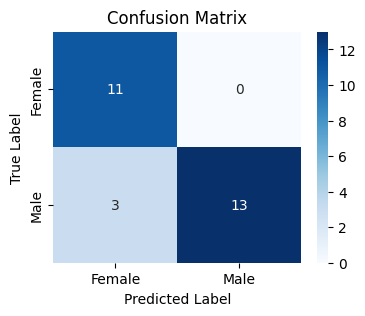

In [9]:
lr_model1 = LogisticRegression(solver="liblinear", C=0.21544346900318834, penalty= 'l1')
model2 = modelers(lr_model1)

lr_model1.fit(X_train,y_train)
prediction = lr_model1.predict(X_test)
prediction_tr = lr_model1.predict(X_train)
# Generate confusion matrix
cm = confusion_matrix(y_test, prediction)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [13]:
lr_model = LogisticRegression(solver="liblinear", max_iter=10000)

params={"C":np.logspace(-2,2,10), "penalty":["l2"]}
gscv = GridSearchCV(lr_model,params)
score_best_estimator = gscv.fit(X_train, y_train).score(X_test, y_test)
print('the highest accuracy score is: {:.3f}'.format(gscv.best_score_))
print('the best hyperparameter combination is:\ {}'.format(gscv.best_params_))

the highest accuracy score is: 0.875
the best hyperparameter combination is:\ {'C': 0.21544346900318834, 'penalty': 'l2'}


In [14]:
lr_model2 = LogisticRegression(solver="liblinear", C = 0.21544346900318834, penalty= 'l2')
model21 = modelers(lr_model2)

Accuracy on train data:  94.23%
Cross Validation Score :  91.97%
Accuracy on test data:  59.26%
ROC_AUC Score :  50.00%


In [15]:
grids = {
    'min_samples_leaf': [1, 2, 5, 10],
    'n_estimators': [10, 20, 50],
    'max_depth': [2, 5, 10]
}

# Initialize RandomForestClassifier with a fixed random state
randf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
# Using StratifiedKFold for cross-validation to avoid randomness
gscv = GridSearchCV(randf, grids, scoring='accuracy')

# Fit GridSearchCV
score_best_estimator = gscv.fit(X_train, y_train).score(X_test, y_test)

# Print results
print('The highest accuracy score is: {:.3f}'.format(gscv.best_score_))
print('The best hyperparameter combination is: {}'.format(gscv.best_params_))

The highest accuracy score is: 0.874
The best hyperparameter combination is: {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 50}


In [16]:
rf = RandomForestClassifier(max_depth=2, n_estimators=50, min_samples_leaf=5)
model3=modelers(rf)

Accuracy on train data:  94.23%
Cross Validation Score :  91.21%
Accuracy on test data:  62.96%
ROC_AUC Score :  64.49%


In [17]:
svc1 = SVC()
model4 =modelers(svc1)

Accuracy on train data:  97.12%
Cross Validation Score :  93.13%
Accuracy on test data:  59.26%
ROC_AUC Score :  50.00%


In [18]:
knn =KNN()

params= {'n_neighbors': [3, 5, 7, 9]}
gscv=GridSearchCV(knn, params, scoring='accuracy',cv=4, n_jobs=-1)
score_best_estimator = gscv.fit(X_train, y_train).score(X_test, y_test)
print('the highest accuracy score is: {:.3f}'.format(gscv.best_score_))
print('the best hyperparameter combination is:\ {}'.format(gscv.best_params_))

the highest accuracy score is: 0.856
the best hyperparameter combination is:\ {'n_neighbors': 7}


In [19]:
knn1 = KNN(7)
model5 = modelers(knn1)

Accuracy on train data:  89.42%
Cross Validation Score :  88.18%
Accuracy on test data:  59.26%
ROC_AUC Score :  50.00%


In [21]:
adaboost = AdaBoostClassifier(algorithm='SAMME')
params = {'n_estimators': [10, 20, 50], 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]}

gscv=GridSearchCV(adaboost, params, scoring='accuracy', n_jobs=-1)
score_best_estimator = gscv.fit(X_train, y_train).score(X_test, y_test)
print('the highest accuracy score is: {:.3f}'.format(gscv.best_score_))
print('the best hyperparameter combination is:\ {}'.format(gscv.best_params_))

the highest accuracy score is: 0.827
the best hyperparameter combination is:\ {'learning_rate': 0.1, 'n_estimators': 10}


In [22]:
adaboost1 = AdaBoostClassifier(learning_rate=0.1, n_estimators=10, algorithm='SAMME')

model6 = modelers(adaboost1)

Accuracy on train data:  85.58%
Cross Validation Score :  87.70%
Accuracy on test data:  62.96%
ROC_AUC Score :  68.75%


In [24]:
gboost = GradientBoostingClassifier()
params = {'learning_rate':[0.1,0.01,0.2,0.5],
         'n_estimators':[10,20,50],
         'min_samples_split':[2,3,5],
         'min_samples_leaf':[1,2,5,10]}

gscv = GridSearchCV(gboost,params)
score_best_estimator = gscv.fit(X_train, y_train).score(X_test, y_test)
print('the highest accuracy score is: {:.3f}'.format(gscv.best_score_))
print('the best hyperparameter combination is:\ {}'.format(gscv.best_params_))

the highest accuracy score is: 0.875
the best hyperparameter combination is:\ {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}


In [26]:
gboost1 = GradientBoostingClassifier(learning_rate=0.1, min_samples_leaf=10, min_samples_split=5, n_estimators=10)
model7 = modelers(gboost1)

Accuracy on train data:  94.23%
Cross Validation Score :  89.34%
Accuracy on test data:  77.78%
ROC_AUC Score :  75.57%


Live Audio Recognition

In [1]:
!pip install wavio
!pip install ffmpeg

In [13]:
import sounddevice as sd
import wavio
import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write

In [37]:
def list_devices():
    """ List all available audio input and output devices. """
    print(sd.query_devices())


def record_audio(duration=5, fs=44100, channels=1, filename='live_recorded_voice.wav'):
    print("Recording...")
    try:
        recording = sd.rec(int(duration * fs), samplerate=fs, channels=channels, dtype='float32')
        sd.wait()  # Wait until recording is finished
        wavio.write(filename, recording, fs, sampwidth=2)
        print("Recording and file saving complete")
        return filename
    except Exception as e:
        print(f"Failed to record or save audio: {e}")
        return None


def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)  # Using `sr=None` to preserve original sampling rate
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
        if np.any(np.isnan(mfccs)) or np.any(np.isinf(mfccs)):
            raise ValueError("NaN or Inf in extracted MFCCs")
        mfccs_mean = np.mean(mfccs, axis=1)
        print(f"Features extracted successfully: {mfccs_mean.shape}")
        return mfccs_mean.reshape(1, -1)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

list_devices()



   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Набор микрофонов (Технология In, MME (2 in, 0 out)
   2 Микрофон (Steam Streaming Micro, MME (2 in, 0 out)
   3 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  4 Speaker (Realtek(R) Audio), MME (0 in, 2 out)
   5 Динамики (Steam Streaming Speak, MME (0 in, 2 out)
   6 Динамики (Steam Streaming Micro, MME (0 in, 2 out)
   7 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   8 Набор микрофонов (Технология Intel® Smart Sound), Windows DirectSound (2 in, 0 out)
   9 Микрофон (Steam Streaming Microphone), Windows DirectSound (2 in, 0 out)
  10 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  11 Speaker (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
  12 Динамики (Steam Streaming Speakers), Windows DirectSound (0 in, 2 out)
  13 Динамики (Steam Streaming Microphone), Windows DirectSound (0 in, 2 out)
  14 Динамики (Steam Streaming Speakers), Windows WASAPI (0 in, 2 out)
  15 Динамики (Steam Stre

In [38]:
def predict_gender(model, features):
    try:
        print("Predicting gender...")
        prediction = model.predict(features)[0]
        probability = model.predict_proba(features)[0]
        gender = 'male' if prediction == 1 else 'female'
        print(f"Predicted Gender: {gender}")
        print(f"Probability Male: {probability[1]*100:.2f}%   Female: {probability[0]*100:.2f}%")
    except Exception as e:
        print(f"An error occurred during prediction: {e}")

def main():
    filename = record_audio()
    if filename is None:
        print("Recording failed.")
        return
    
    features = extract_features(filename)
    if features is None:
        print("Feature extraction failed.")
        return
    
    if model2 is None:
        print("Model not initialized.")
        return

    predict_gender(model2, features)

if __name__ == "__main__":
    main()



Recording...
Recording and file saving complete
Features extracted successfully: (20,)
Predicting gender...
Predicted Gender: male
Probability Male: 59.54%   Female: 40.46%
